# Proyecto 3: Clustering

## Integrantes:

- Alvaro Mauricio Garcia Hurtado (100%)
- Sergio Ramon Cortez de la Cruz (100%)
- Jose Francisco Wong Orrillo (100%)

In [ ]:
# Instalaciones requeridas
# !pip install numpy
# !pip install matplotlib
# !pip install scikit-learn
# !pip install umap-learn

El procesamiento del dataset de videos se encuentra en el siguiente [proyecto](https://github.com/JoseFrancisc0/video_feature_extraction/tree/main).

Los feature vectors de cada uno de los videos se encuentra en el archivo training_features.csv

Los labels de cada uno de los videos se encuentra en el archivo training_labels.csv

Puede descargar los archivos [aquí](https://drive.google.com/drive/folders/1ms0EzOt9Wk45ABPjb3cjfC5rT-YZjWUm?usp=sharing).

In [10]:
import numpy as np
import os

os.environ['LOKY_MAX_CPU_COUNT'] = '2'

X = np.genfromtxt('training_features.csv', delimiter=',', skip_header=1, dtype=float)
Y = np.genfromtxt('training_labels.csv', delimiter=',', skip_header=1, dtype=str)

Métodos de reducción de dimensionalidad usados: PCA, SVD, tSNE y UMAP

In [11]:
# Reduccion de dimensionalidad
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import root_mean_squared_error
from sklearn.manifold import TSNE
from umap import UMAP

def reduce_with_PCA(X, n):
    pca = PCA(n_components=n, random_state=60)
    X_new = pca.fit_transform(X)
    X_rec = pca.inverse_transform(X_new)
    error = root_mean_squared_error(X, X_rec)
    return X_new, error

def reduce_with_SVD(X, n):
    svd = TruncatedSVD(n_components=n, random_state=60)
    X_new = svd.fit_transform(X)
    X_rec = svd.inverse_transform(X_new)
    error = root_mean_squared_error(X, X_rec)
    return X_new, error

def reduce_with_TSNE(X, n):
    tsne = TSNE(n_components=n, random_state=60)
    X_new = tsne.fit_transform(X)
    return X_new

def reduce_with_UMAP(X, n):
    umap = UMAP(n_components=n, random_state=60)
    X_new = umap.fit_transform(X)
    return X_new

Para evaluar los métodos y su efectividad, tenemos dos funciones: ploteo de data en 2D y scores de clustering.

In [12]:
# Evaluacion de metodos
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder

def Plot_2D(data, labels, method):
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)

    plt.figure(figsize=(8, 6))
    plt.scatter(x=data[:, 0], y=data[:, 1], c=encoded_labels, cmap='viridis', s=10, alpha=0.7)
    plt.colorbar()
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(f"Visualizacion 2D del Dataset con {method}")
    plt.show()

def Score_Clusters(X, Y, cluster_labels):
    scores = {}
    scores["Silhouette Score"] = silhouette_score(X=X, labels=cluster_labels)
    scores["Adjusted RI Index"] = adjusted_rand_score(labels_true=Y, labels_pred=cluster_labels)
    scores["Adjusted MI score"] = adjusted_mutual_info_score(labels_true=Y, labels_pred=cluster_labels)
    return scores

Modelos de clustering implementados: K-Means y Agglomerative Clustering.

In [15]:
# K-Means implementation
import random

class K_Means_Own:
    def __init__(self, k, epochs, tol):
        self.k = k
        self.epochs = epochs
        self.tol = tol
        self.centroides = None
        self.clusters = None

    def distance(self, v1, v2):
        return np.linalg.norm(v2 - v1)

    def init_centroide(self, data):
        random.seed(60)
        centroides = [data[random.randint(0, len(data)-1)]]
        for _ in range(1, self.k):
            distances = np.array([min(np.linalg.norm(x - centroid)**2 for centroid in centroides) for x in data])
            probs = distances / distances.sum()
            cumulative_probs = np.cumsum(probs)
            r = random.random()

            for j, p in enumerate(cumulative_probs):
                if r < p:
                    centroides.append(data[j])
                    break
        self.centroides = np.array(centroides)

    def update_centroide(self, data, clusters):
        new_centroids = []
        for i in range(self.k):
              cluster = [data[j] for j in range(len(data)) if clusters[j] == i]
              new_centroids.append(np.mean(cluster, axis=0))
        return np.array(new_centroids)

    def cambio_de_centroide(self, old_centroide, new_centroide):
        return np.mean([self.distance(old_centroide[i], new_centroide[i]) for i in range(len(old_centroide))])

    def get_cluster(self, data):
        clusters = np.zeros(len(data))
        for i in range(len(data)):
            dist = np.inf
            for j in range(len(self.centroides)):
                if self.distance(data[i], self.centroides[j]) < dist:
                    dist = self.distance(data[i], self.centroides[j])
                    clusters[i] = j
        return clusters

    def fit_predict(self, data):
        self.init_centroide(data)
        clusters = self.get_cluster(data)
        new_centroides = self.update_centroide(data, clusters)
        for i in range(self.epochs):
            if self.cambio_de_centroide(self.centroides, new_centroides) < self.tol:
                break
            self.centroides = new_centroides
            clusters = self.get_cluster(data)
            new_centroides = self.update_centroide(data, clusters)

        self.clusters = clusters
        return self.clusters

In [381]:
import heapq
from itertools import product, combinations
import math

class Agglomerative_Clustering_Own:
    def __init__(self, data, n_clusters, dist='single-link'):
        self.data = [tuple(point) for point in data]
        self.n_clusters = n_clusters
        self.dist = dist
        self.batch_size = 100
        self.clusters = set()
        self.final_labels = {point: -1 for point in self.data}
        self.distance_cache = {}
        self.distance_metrics = {
            'single-link': self.single_link,
            'complete-link': self.complete_link
        }
        
        if dist not in self.distance_metrics:
            raise ValueError(f"Distance Metric '{dist}' not recognized. Choose from {list(self.distance_metrics.keys())}.")
    
    def plane_euclidean_distance(self, point_a, point_b):
        return round(math.sqrt((point_a[0] - point_b[0]) ** 2 + (point_a[1] - point_b[1]) ** 2), 2)

    def single_link(self, cluster_a, cluster_b):
        return min(self.plane_euclidean_distance(p1, p2) for p1, p2 in product(cluster_a, cluster_b))

    def complete_link(self, cluster_a, cluster_b):
        max_distance = float('-inf')
        for p1 in cluster_a:
            for p2 in cluster_b:
                distance = self.plane_euclidean_distance(p1, p2)
                if distance > max_distance:
                    max_distance = distance
                if max_distance > 5.0:
                    return max_distance

        return max_distance
    
    def compute_distance(self, cluster_a, cluster_b):
        pair = frozenset([cluster_a, cluster_b])
        if pair not in self.distance_cache:
            self.distance_cache[pair] = self.distance_metrics[self.dist](cluster_a, cluster_b)
        return self.distance_cache[pair]

    def fit_predict(self):
        for batch_start in range(0, len(self.data), self.batch_size):
            batch_data = self.data[batch_start:batch_start + self.batch_size]
            batch_clusters = {frozenset([point]) for point in batch_data}
            
            while len(batch_clusters) > self.n_clusters:
                min_dist = float('inf')
                cluster_a, cluster_b = None, None

                for c1, c2 in combinations(batch_clusters, 2):
                    distance = self.compute_distance(c1, c2)
                    if distance < min_dist:
                        min_dist = distance
                        cluster_a, cluster_b = c1, c2

                new_cluster = cluster_a | cluster_b
                batch_clusters.remove(cluster_a)
                batch_clusters.remove(cluster_b)
                batch_clusters.add(frozenset(new_cluster))
            
            self.clusters.update(batch_clusters)
        
        cluster_pairs = []
        for c1, c2 in combinations(self.clusters, 2):
            distance = self.compute_distance(c1, c2)
            heapq.heappush(cluster_pairs, (distance, c1, c2))

        while len(self.clusters) > self.n_clusters:
            _, cluster_a, cluster_b = heapq.heappop(cluster_pairs)
            if cluster_a in self.clusters and cluster_b in self.clusters:
                new_cluster = cluster_a | cluster_b
                self.clusters.remove(cluster_a)
                self.clusters.remove(cluster_b)
                self.clusters.add(frozenset(new_cluster))
                
                for other_cluster in self.clusters:
                    if other_cluster != new_cluster:
                        distance = self.compute_distance(new_cluster, other_cluster)
                        heapq.heappush(cluster_pairs, (distance, new_cluster, other_cluster))

        for idx, cluster in enumerate(self.clusters):
            for point in cluster:
                self.final_labels[point] = idx
        
        cluster_labels = [self.final_labels[point] for point in self.data]
        return cluster_labels

In [378]:
# Modelos de clustering

def K_Means(X):
    km = K_Means_Own(k=20, epochs=300, tol=0.0001)
    cluster_labels = km.fit_predict(X)
    return cluster_labels

def Agglomerative_Clustering(X):
    agg = Agglomerative_Clustering_Own(data=X, n_clusters=20, dist='complete-link')
    cluster_labels = agg.fit_predict()
    return cluster_labels

## MAIN

Actualmente nuestro dataset cuenta con 512 features, así que se procedió a la reducción de dimensiones con los métodos implementados. Primero se usó uno de los modelos para reducir a 50 dimensiones, luego aplicamos UMAP al dataset resultante para reducirlo hasta 2 dimensiones.

Como forma de evaluar los modelos, tenemos el error de reconstrucción y el ploteo en 2 dimensiones.

Error with PCA 512->50: 0.28883149395605684


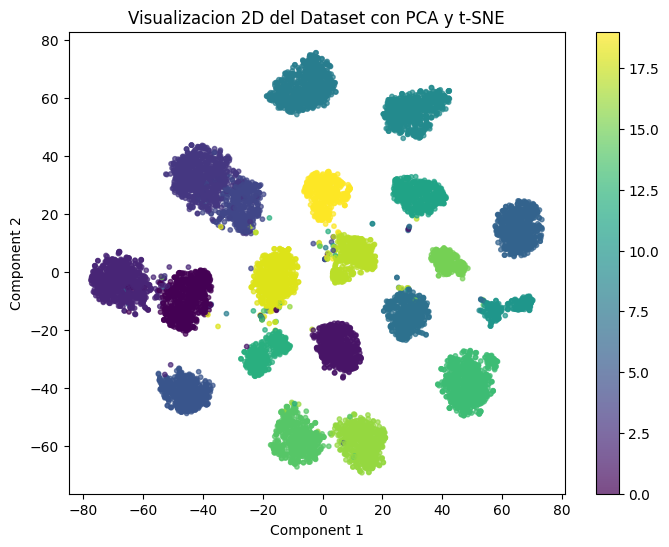

c:\Users\josew\Desktop\utec\2024.2 - 8vo Ciclo\Machine Learning\ML_Proyecto3\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


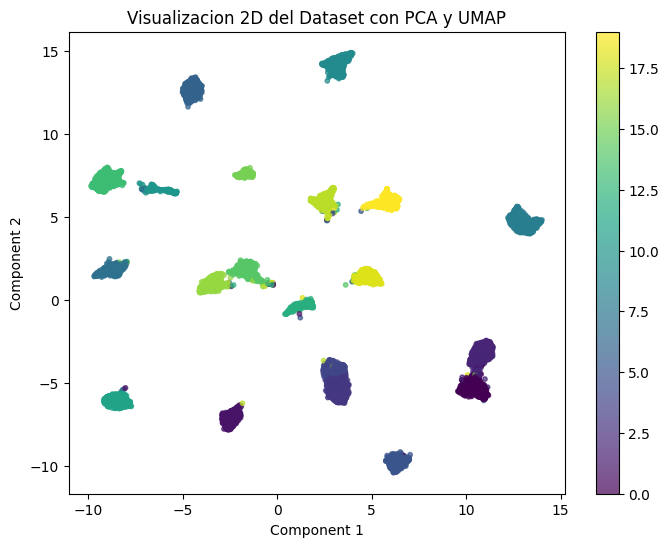

In [20]:
# Reduciendo dimensiones con PCA

X_PCA, error = reduce_with_PCA(X, 50)
print(f'Error with PCA 512->50: {error}')

X_TSNE_PCA = reduce_with_TSNE(X_PCA, 2)
Plot_2D(data=X_TSNE_PCA, labels=Y, method="PCA y t-SNE")

X_UMAP_PCA = reduce_with_UMAP(X_PCA, 2)
Plot_2D(data=X_UMAP_PCA, labels=Y, method="PCA y UMAP")

Error with SVD 512->50: 0.2896391143238428


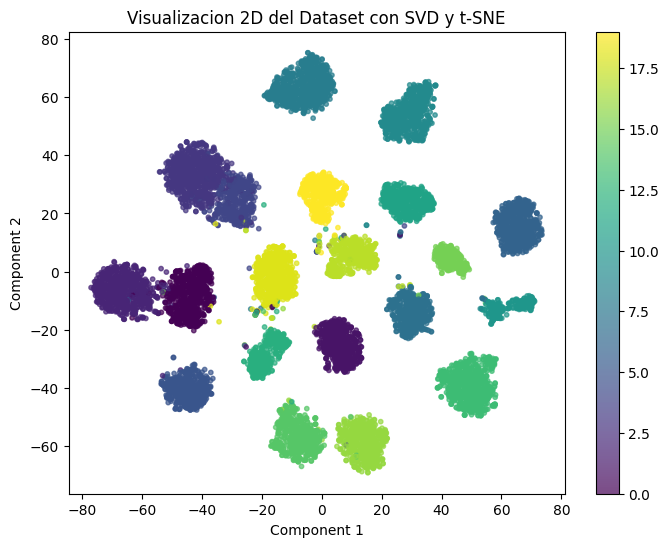

c:\Users\josew\Desktop\utec\2024.2 - 8vo Ciclo\Machine Learning\ML_Proyecto3\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


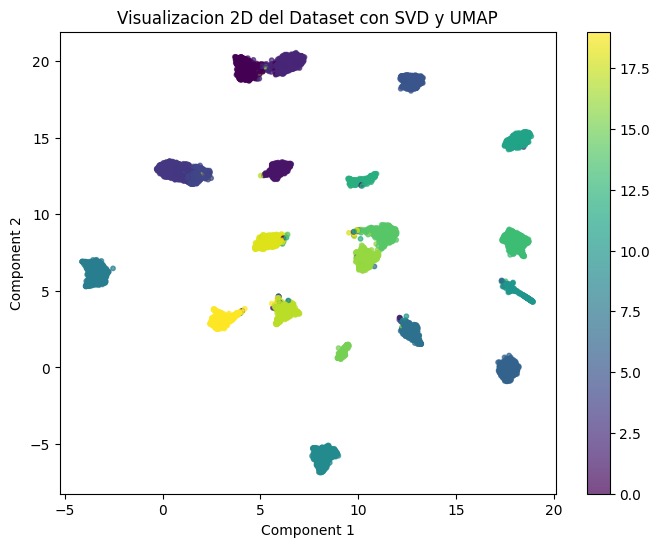

In [21]:
# Reduciendo dimensiones con SVD

X_SVD, error = reduce_with_SVD(X, 50)
print(f'Error with SVD 512->50: {error}')

X_TSNE_SVD = reduce_with_TSNE(X_SVD, 2)
Plot_2D(data=X_TSNE_SVD, labels=Y, method="SVD y t-SNE")

X_UMAP_SVD = reduce_with_UMAP(X_SVD, 2)
Plot_2D(data=X_UMAP_SVD, labels=Y, method="SVD y UMAP")

Ahora usamos los modelos de clustering implementados para obtener los scores.

In [379]:
# Aplicando clustering con K-Means

pred1 = K_Means(X_TSNE_PCA)
pred2 = K_Means(X_TSNE_SVD)
pred3 = K_Means(X_UMAP_PCA)
pred4 = K_Means(X_UMAP_SVD)

scores_KMeans = [Score_Clusters(X_TSNE_PCA, Y , pred1), Score_Clusters(X_TSNE_SVD, Y , pred2), Score_Clusters(X_UMAP_PCA, Y , pred3), Score_Clusters(X_UMAP_SVD, Y , pred4)]
for entry in scores_KMeans:
    print(entry)

{'Silhouette Score': np.float32(0.6063742), 'Adjusted RI Index': 0.8551855613746226, 'Adjusted MI score': np.float64(0.9376215220876601)}
{'Silhouette Score': np.float32(0.57286024), 'Adjusted RI Index': 0.8543260349458449, 'Adjusted MI score': np.float64(0.9226873805737409)}
{'Silhouette Score': np.float32(0.7760732), 'Adjusted RI Index': 0.8556562221396541, 'Adjusted MI score': np.float64(0.9411968066418441)}
{'Silhouette Score': np.float32(0.7601594), 'Adjusted RI Index': 0.8827019719856383, 'Adjusted MI score': np.float64(0.9471120609096488)}


In [382]:
# Aplicando clustering con Agglomerative Clustering

pred5 = Agglomerative_Clustering(X_TSNE_PCA)
pred6 = Agglomerative_Clustering(X_TSNE_SVD)
pred7 = Agglomerative_Clustering(X_UMAP_PCA)
pred8 = Agglomerative_Clustering(X_UMAP_SVD)

scores_Agglo = [Score_Clusters(X_TSNE_PCA, Y , pred5), Score_Clusters(X_TSNE_SVD, Y , pred6), Score_Clusters(X_UMAP_PCA, Y , pred7), Score_Clusters(X_UMAP_SVD, Y , pred8)]
for entry in scores_Agglo:
    print(entry)

{'Silhouette Score': np.float32(0.4449974), 'Adjusted RI Index': 0.7906009367071212, 'Adjusted MI score': np.float64(0.8982713329935872)}
{'Silhouette Score': np.float32(0.48666483), 'Adjusted RI Index': 0.8120130448038129, 'Adjusted MI score': np.float64(0.8966227106513619)}
{'Silhouette Score': np.float32(0.7867771), 'Adjusted RI Index': 0.9483455290649848, 'Adjusted MI score': np.float64(0.9623596044775616)}
{'Silhouette Score': np.float32(0.783608), 'Adjusted RI Index': 0.9500365142846872, 'Adjusted MI score': np.float64(0.962179620599923)}


Ahora ploteamos los scores para mejor visualización y simplificar el análisis de los resultados.

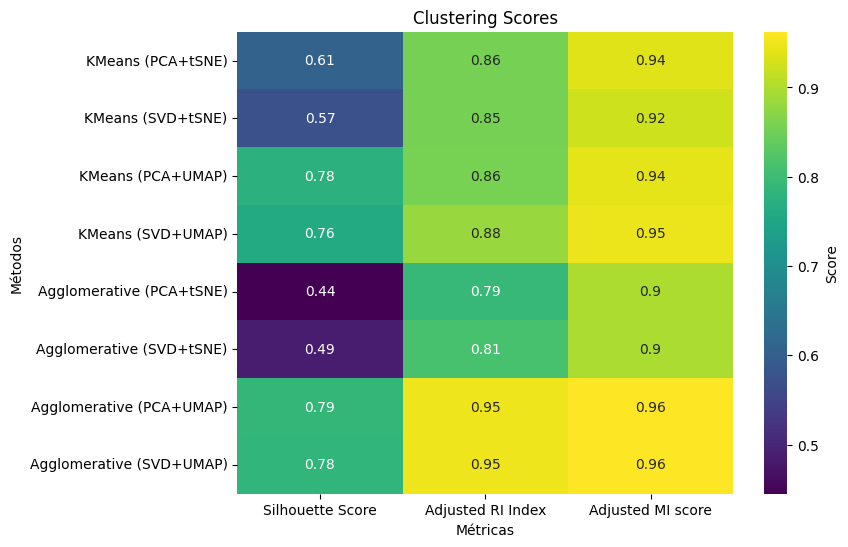

In [383]:
import pandas as pd
import seaborn as sns

methods = ["KMeans (PCA+tSNE)", "KMeans (SVD+tSNE)", "KMeans (PCA+UMAP)", "KMeans (SVD+UMAP)",
           "Agglomerative (PCA+tSNE)", "Agglomerative (SVD+tSNE)", "Agglomerative (PCA+UMAP)", "Agglomerative (SVD+UMAP)"]
metrics = list(scores_KMeans[0].keys())
s = scores_KMeans + scores_Agglo
scores = [list(score.values()) for score in s]

df = pd.DataFrame(scores, columns=metrics, index=methods)

plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap='viridis', cbar_kws={'label': 'Score'})
plt.title('Clustering Scores')
plt.xlabel('Métricas')
plt.ylabel('Métodos')
plt.show()